In [1]:
import operator
from typing import Annotated, List, Literal, Sequence, TypedDict

import tiktoken
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.tools import YouTubeSearchTool
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import (ChatGoogleGenerativeAI,
                                    GoogleGenerativeAIEmbeddings)
from langchain_groq import ChatGroq
from langchain_ollama import OllamaLLM
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, Graph, MessagesState, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import tool

/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
load_dotenv()
llama = OllamaLLM(model="llama3.2")
gemini = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
model = ChatGroq(model_name="gemma2-9b-it")
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

#### Simple Langgraph Chain

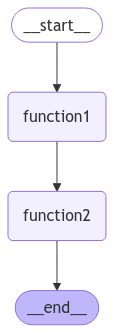

'Hello I am bishwayan from function1 & hello from function2 as well.'

In [3]:
def function1(input):
    return input + " from function1"


def function2(input):
    return input + " & hello from function2 as well."


workflow1 = Graph()
workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")
workflow1.add_edge("function1", "function2")

app1 = workflow1.compile()
display(Image(app1.get_graph().draw_mermaid_png()))
app1.invoke("Hello I am bishwayan")

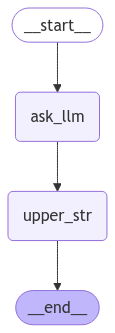

AttributeError: 'AIMessage' object has no attribute 'upper'

In [4]:
def ask_llm(query: str):
    return model.invoke(query)


def make_str_uppercase(input: str):
    return input.upper()


wf2 = Graph()
wf2.add_node("ask_llm", ask_llm)
wf2.add_node("upper_str", make_str_uppercase)

wf2.set_entry_point("ask_llm")
wf2.set_finish_point("upper_str")
wf2.add_edge("ask_llm", "upper_str")

app2 = wf2.compile()
display(Image(app2.get_graph().draw_mermaid_png()))

print(app2.invoke("Tell me in 3 sentences, what is LSTM?"))

In [4]:
def calculate_tokens(input: str):
    tokenizer = tiktoken.get_encoding("cl100k_base")
    tokens = tokenizer.encode(input)
    return f"number of tokens in the llm output is: {len(tokens)}"


wf3 = Graph()
wf3.add_node("ask_llm", ask_llm)
wf3.add_node("upper_str", make_str_uppercase)
wf3.add_node("token_count", calculate_tokens)

wf3.set_entry_point("ask_llm")
wf3.set_finish_point("token_count")
wf3.add_edge("ask_llm", "upper_str")
wf3.add_edge("upper_str", "token_count")

app3 = wf3.compile()
print(app3.invoke("What is deepfake? Explain in 2 sentences"))

number of tokens in the llm output is: 127


#### Langgraph with RAG agent

In [39]:
file_path = "/home/bishwayansaha99/langchain/docs/attention.pdf"
loader = PyPDFLoader(file_path=file_path)
documents = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
doc_chunks = splitter.split_documents(documents=documents)
chromadb = Chroma.from_documents(documents=doc_chunks, embedding=embedding)

retriever = chromadb.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 3, "score_threshold": 0.5},
)

retrieved_docs = retriever.invoke("What is attention?")
for doc in retrieved_docs:
    print(doc.page_content)
    print(doc.metadata)

√dk
)V (1)
The two most commonly used attention functions are additive attention [2], and dot-product (multi-
plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor
of 1√dk
. Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is
much faster and more space-efficient in practice, since it can be implemented using highly optimized
matrix multiplication code.
While for small values of dk the two mechanisms perform similarly, additive attention outperforms
dot product attention without scaling for larger values of dk [3]. We suspect that for large values of
dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has
extremely small gradients 4. To counteract this effect, we scale the dot products by 1√dk
.
3.2.2 Multi-Head Attention
{'page': 3, 'source': '/home/bishwa

In [6]:
def llm_call(AgentState: dict[str: List]):
    question = AgentState["messages"][-1]

    prompt_template = ChatPromptTemplate.from_template(
        """
            Give a very brief description about the answer of the question.
            Do not return any unncessary prefix, suffix, special character or escape characters
            Here is the question: {question}
        """
    )
    chain = prompt_template | model
    response = chain.invoke({"question": question})
    AgentState["messages"].append(response)
    return AgentState


def rag_call(AgentState: dict[str: List]):
    question = AgentState["messages"][0]

    prompt_template = ChatPromptTemplate.from_template(
        """
            Answer the following question based on the given context only.\n
            here is the context. \n
            {context}
            \nDo not create or generate any content by yourself. If you don't find any relevant context, return I don't know.
            Qustion: {question}                                     
        """
    )
    rag_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt_template
        | model
        | StrOutputParser()
    )
    return rag_chain.invoke(question)


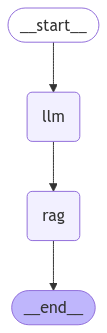

 ===== Output from node: llm =====

{'messages': ['What is attention model?', 'A machine learning algorithm designed to focus on relevant input data.']}
 ===== Output from node: rag =====

According to the given context, an "attention model" refers to a Transformer architecture that uses multi-head attention in three different ways:

1. In "encoder-decoder attention" layers, where queries come from a single sequence in order to compute a representation of the sequence.
2. Self-attention has been used successfully in various tasks such as reading comprehension, abstractive summarization, textual entailment, and learning task-independent sentence representations.
3. End-to-end memory networks use recurrent attention mechanisms instead of sequence-aligned recurrence.

In general, it seems that an "attention model" is a type of neural network architecture that relies on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution.


In [7]:
wf4 = Graph()
wf4.add_node("llm", llm_call)
wf4.add_node("rag", rag_call)

wf4.set_entry_point("llm")
wf4.set_finish_point("rag")
wf4.add_edge("llm", "rag")

app4 = wf4.compile()

display(Image(app4.get_graph().draw_mermaid_png()))

user_question = {"messages": ["What is attention model?"]}
for res in app4.stream(input=user_question):
    for key, value in res.items():
        print(f" ===== Output from node: {key} =====\n") 
        print(value)

#### Conditional Agent

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="Selected topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [7]:
def route(state):
    message = state["messages"][-1]
    if "Attention" in message:
        print("===== Routing to RAG CALL =====")
        return "RAG CALL"
    print("===== Routing to LLM CALL =====")
    return "LLM CALL"

In [36]:
def classify_query(state):
    question = state["messages"][-1]
    print(f"user question is: {question}")
    prompt_template = ChatPromptTemplate.from_template("""
                Your task is to identify the query and classify it into either of the categories [Attention, Other].
                Only provide the category name, no other words or characters.
                Here is the query: {question}
             
            """
    )
    chain = prompt_template | model.with_structured_output(TopicSelectionParser)
    response: TopicSelectionParser = chain.invoke(
        {"question": question}
    )
    print(response)
    return {"messages": [response.Topic]}

In [ ]:
print(classify_query({"messages": ["What is attention model ?"]}))

user question is: What is attention model ?
Topic='Attention' Reasoning='Query about attention model'
{'messages': ['Attention']}


In [40]:
def execute_rag_node(state):
    print("===== RAG function execution =====")

    print(state)
    question = state["messages"][0]
    print(question)
    prompt_template = ChatPromptTemplate.from_template(
        """
            Answer the following question based on the given context only.\n
            here is the context. \n
            {context}
            \nDo not create or generate any content by yourself. If you don't find any relevant context, return I don't know.
            Qustion: {question}                                     
        """
    )
    rag_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt_template
        | model
        | StrOutputParser()
    )
    return {"messages" : [rag_chain.invoke(question)]}

In [41]:
def execute_llm_node(state):
    print("===== LLM function execution =====")

    question = state["messages"][0]
    prompt_template = ChatPromptTemplate.from_template(
        """
            You are a smart AI assistant who has a profound knowledge on deep learning.\n
            You have to give answer to the following question in a very simple manner with layman's terms.
            Qustion: {question}                                     
        """
    )

    chain = prompt_template | model | StrOutputParser()
    return {"messages" : [chain.invoke({"question": question})]}

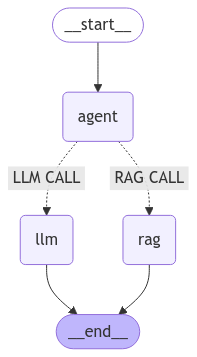

In [42]:
wf5 = StateGraph(AgentState)

wf5.add_node("llm", execute_llm_node)
wf5.add_node("rag", execute_rag_node)
wf5.add_node("agent", classify_query)

wf5.set_entry_point("agent")
wf5.add_conditional_edges("agent", route, {"RAG CALL": "rag", "LLM CALL": "llm"})
wf5.add_edge("llm", END)
wf5.add_edge("rag", END)

app5 = wf5.compile()

display(Image(app5.get_graph().draw_mermaid_png()))

# for res in app5.stream({"messages": ["What is an attention model?"]}):
#     for k, v in res.items():
#         print(f"===== Output at node {k} =====")
#         print(v)


In [45]:
print(app5.invoke({"messages": ["What is an attention model?"]})["messages"][-1])

user question is: What is an attention model?
Topic='Attention' Reasoning='Query about attention models'
===== Routing to RAG CALL =====
===== RAG function execution =====
{'messages': ['What is an attention model?', 'Attention']}
What is an attention model?
Based on the provided text, an attention model, specifically self-attention, is used to compute a representation of a sequence.  It has been successfully used in tasks such as reading comprehension, abstractive summarization, textual entailment, and learning task-independent sentence representations.  The Transformer is described as the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution.



#### Langgraph cain with memory

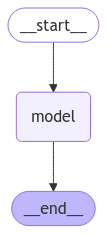

In [5]:
def call_model(state: MessagesState):
    question = state["messages"]
    return {"messages": [llama.invoke(question)]}

wf6 = StateGraph(MessagesState)
wf6.add_node("model", call_model)
wf6.set_entry_point("model")
wf6.set_finish_point("model")

app6 = wf6.compile()
display(Image(app6.get_graph().draw_mermaid_png()))

In [6]:
print(app6.invoke({"messages": ["Hey, my name is Bishwayan Saha"]}))

{'messages': [HumanMessage(content='Hey, my name is Bishwayan Saha', additional_kwargs={}, response_metadata={}, id='fc135614-47db-4fc2-8296-11c38ba8a046'), HumanMessage(content="Hello Bishwayan! It's nice to meet you. I'm happy to chat with you. Is there something on your mind that you'd like to talk about, or would you like me to suggest some conversation topics?", additional_kwargs={}, response_metadata={}, id='c3c41c50-33bf-43d2-8928-3b26a614c3d5')]}


In [7]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [8]:
tools = [search]
tool_node = ToolNode(tools)
llm_with_tools = model.bind_tools(tools)

def caLL_model_with_tool(state: MessagesState):
    question = state["messages"]
    response = llm_with_tools.invoke(question)
    return {"messages": [response]}

In [9]:
caLL_model_with_tool({"messages": ["Weather in India"]})

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z257', 'function': {'arguments': '{"query":"Weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 939, 'total_tokens': 1019, 'completion_time': 0.145454545, 'prompt_time': 0.029989527, 'queue_time': 0.022642073000000002, 'total_time': 0.175444072}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fadfc193-69db-4692-a7a4-0675e7f24bbd-0', tool_calls=[{'name': 'search', 'args': {'query': 'Weather in India'}, 'id': 'call_z257', 'type': 'tool_call'}], usage_metadata={'input_tokens': 939, 'output_tokens': 80, 'total_tokens': 1019})]}

In [13]:
def route(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

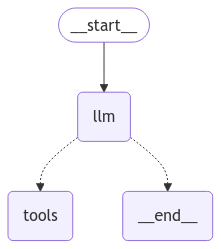

In [15]:
wf7 = StateGraph(MessagesState)
wf7.add_node("llm", caLL_model_with_tool)
wf7.add_node("tools", tool_node)

wf7.add_edge(START, "llm")
wf7.add_conditional_edges("llm", route, {"tools": "tools", END: END})
app7 = wf7.compile()
display(Image(app7.get_graph().draw_mermaid_png()))

In [16]:
app7.invoke({"messages": ["Weather in India"]})

{'messages': [HumanMessage(content='Weather in India', additional_kwargs={}, response_metadata={}, id='0f2db6b9-063d-4426-9d39-56d3d9faeb3b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wtbg', 'function': {'arguments': '{"query":"Weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 939, 'total_tokens': 1021, 'completion_time': 0.149090909, 'prompt_time': 0.033140866, 'queue_time': 0.020436886, 'total_time': 0.182231775}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96660693-f917-4c9b-8fb4-9b003bd0ad7f-0', tool_calls=[{'name': 'search', 'args': {'query': 'Weather in India'}, 'id': 'call_wtbg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 939, 'output_tokens': 82, 'total_tokens': 1021}),
  ToolMessage(content="It's 90 degrees and sunny.", name='search', id='468249aa-3cc8-4028-a592-2f9

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


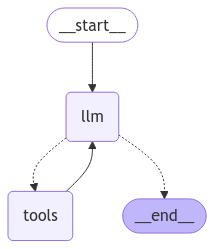

In [18]:
wf7.add_edge("tools", "llm")
app71 = wf7.compile()

display(Image(app71.get_graph().draw_mermaid_png()))

In [19]:
app71.invoke({"messages": ["Weather in sf"]})

{'messages': [HumanMessage(content='Weather in sf', additional_kwargs={}, response_metadata={}, id='120e71c7-e8eb-443d-9035-3e9607c362b8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a5sh', 'function': {'arguments': '{"query":"weather in san francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 939, 'total_tokens': 1020, 'completion_time': 0.147272727, 'prompt_time': 0.03780972, 'queue_time': 0.020661189000000003, 'total_time': 0.185082447}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5fee06c3-2aaa-40b0-a2f2-106728d17833-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in san francisco'}, 'id': 'call_a5sh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 939, 'output_tokens': 81, 'total_tokens': 1020}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='c82117

In [20]:
memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}
app72 = wf7.compile(checkpointer=memory)

event = app72.stream({"messages": ["Weather in sf"]}, config=config, stream_mode="values")
for e in event:
    e["messages"][-1].pretty_print()

================================ Human Message =================================

Weather in sf
================================== Ai Message ==================================
Tool Calls:
  search (call_94hn)
 Call ID: call_94hn
  Args:
    query: Weather in San Francisco
================================= Tool Message =================================
Name: search

It's 60 degrees and foggy.
================================== Ai Message ==================================

It's 60 degrees and foggy.


In [21]:
event = app72.stream({"messages": ["What was my previous question? "]}, config=config, stream_mode="values")
for e in event:
    e["messages"][-1].pretty_print()

================================ Human Message =================================

What was my previous question? 
================================== Ai Message ==================================

Weather in sf
